In [1]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10, CIFAR100
from matplotlib import pyplot as plt
import pickle

In [2]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 3, 32, 32)
    x=torch.transpose(x,1,3)
    x=torch.transpose(x,1,2)
    return x

In [3]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
# Define data loading step

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CIFAR10('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
img, _ = dataset[40000]
print(img.shape)

Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([3, 32, 32])


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
# d = 30  # for standard AE (under-complete hidden layer)
d = 300  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*32*32, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 3*32*32),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [8]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [1/10], loss:0.0299
epoch [2/10], loss:0.0299
epoch [3/10], loss:0.0297
epoch [4/10], loss:0.0285
epoch [5/10], loss:0.0301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [6/10], loss:0.0265
epoch [7/10], loss:0.0300
epoch [8/10], loss:0.0281
epoch [9/10], loss:0.0290
epoch [10/10], loss:0.0270


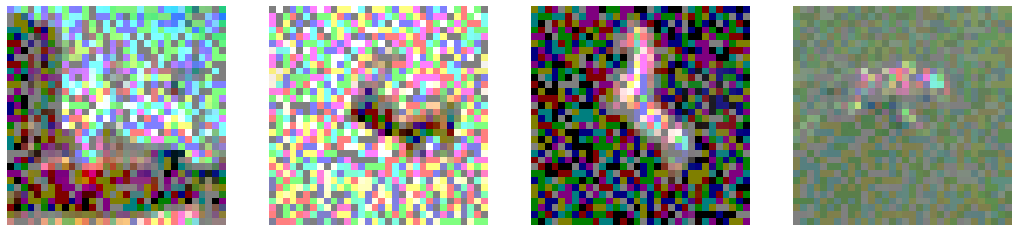

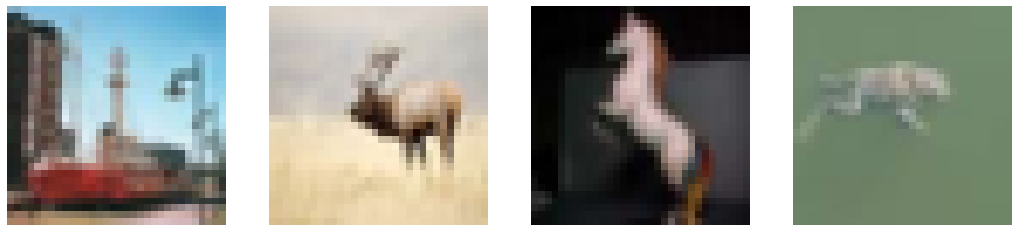

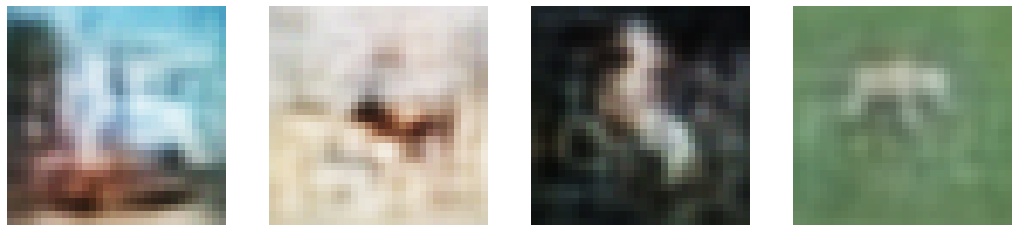

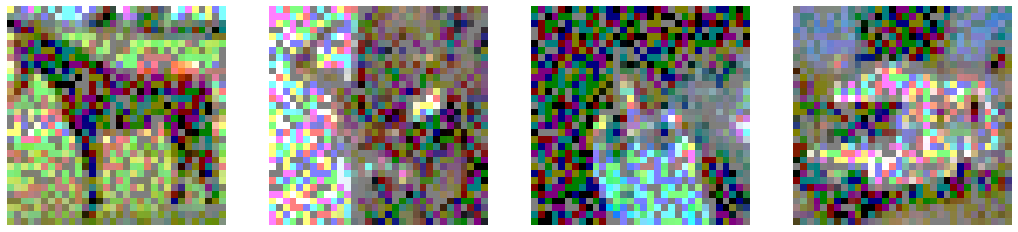

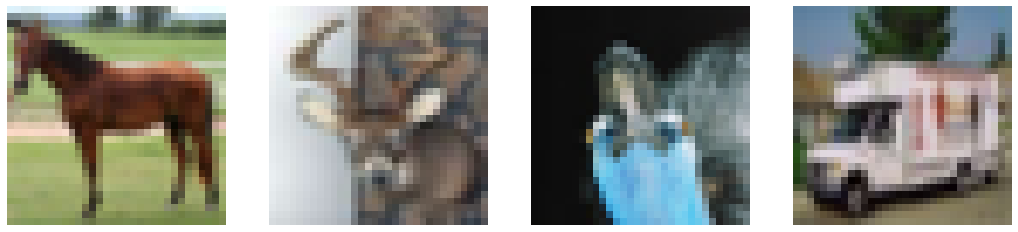

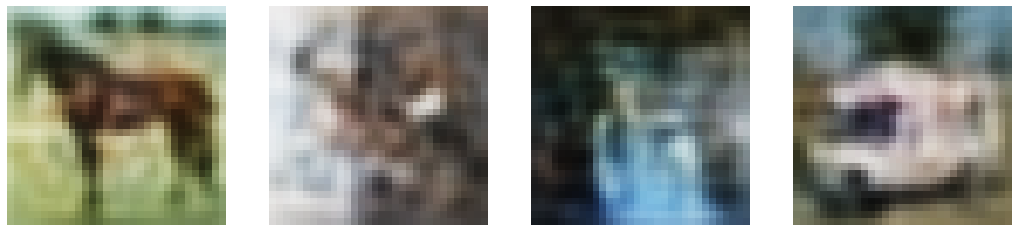

In [10]:
# Train standard or denoising autoencoder (AE)

num_epochs = 10
num_epochs = 12
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    if 5*(epoch//5)==epoch:
        display_images(None, img_bad)
        display_images(None, img)
        display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

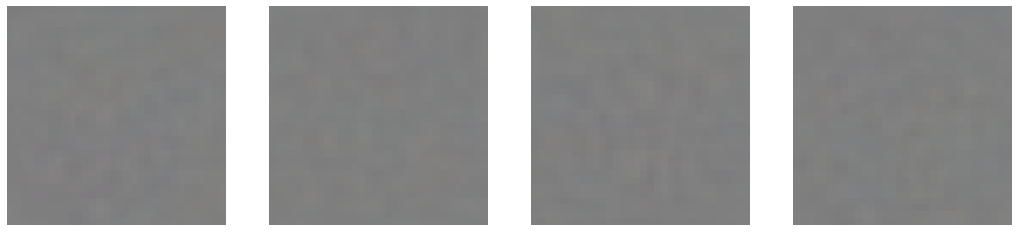

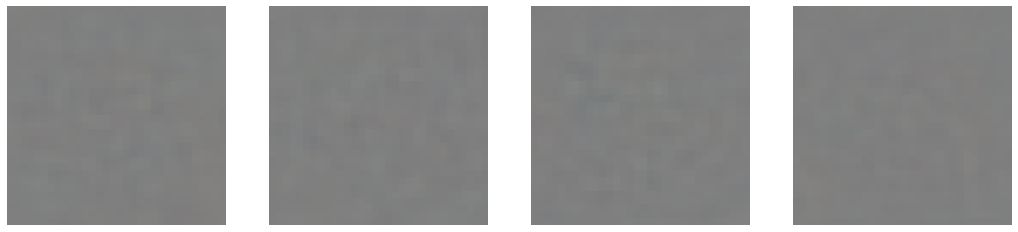

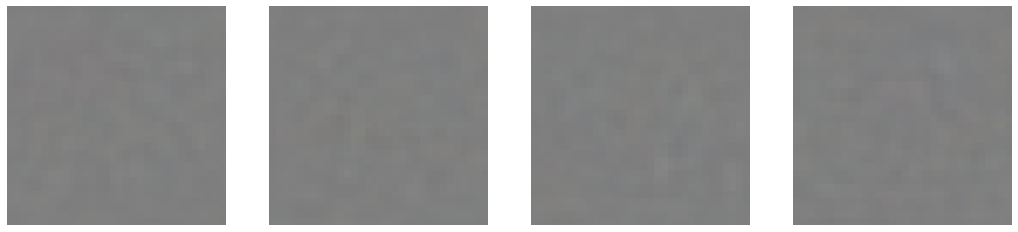

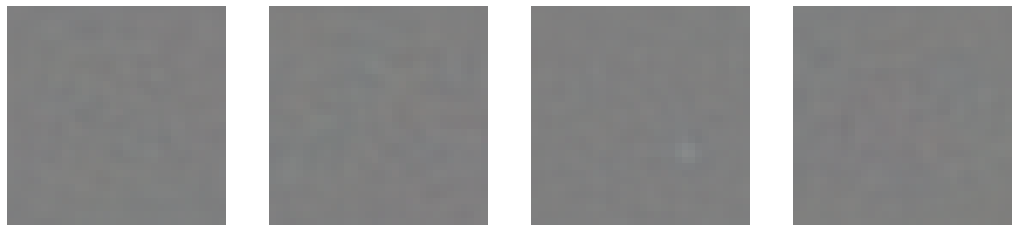

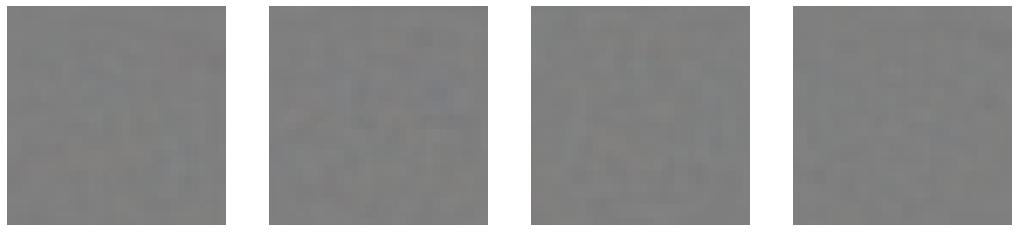

In [71]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

In [72]:
# Let's compare the autoencoder inpainting capabilities vs. OpenCV
# RUN THIS ONLY AFTER HAVING TRAINED A DENOISING AE!!!

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [11]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

NameError: name 'img_bad' is not defined

In [ ]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)